**SPRAWOZDANIE**

Programowanie Równoległe i Rozproszone

Laboratorium nr 8

**Autor**: Mateusz Boguszewski 82613 

________________________________________________________________________________
**Zbiór Julii** - to zbiór punktów w przestrzeni kompleksowej, który jest generowany przez iteracyjne przekształcenie ciągu liczb zespolonych według określonej reguły. Zbiór Julia jest często wykorzystywany w grafice komputerowej do tworzenia abstrakcyjnych obrazów i animacji. Może on również być używany w matematyce do badania własności funkcji kompleksowych. Zbiór Julia jest nazwany na cześć francuskiego matematyka Gastona Julia, który opisał go po raz pierwszy w latach 20. XX wieku.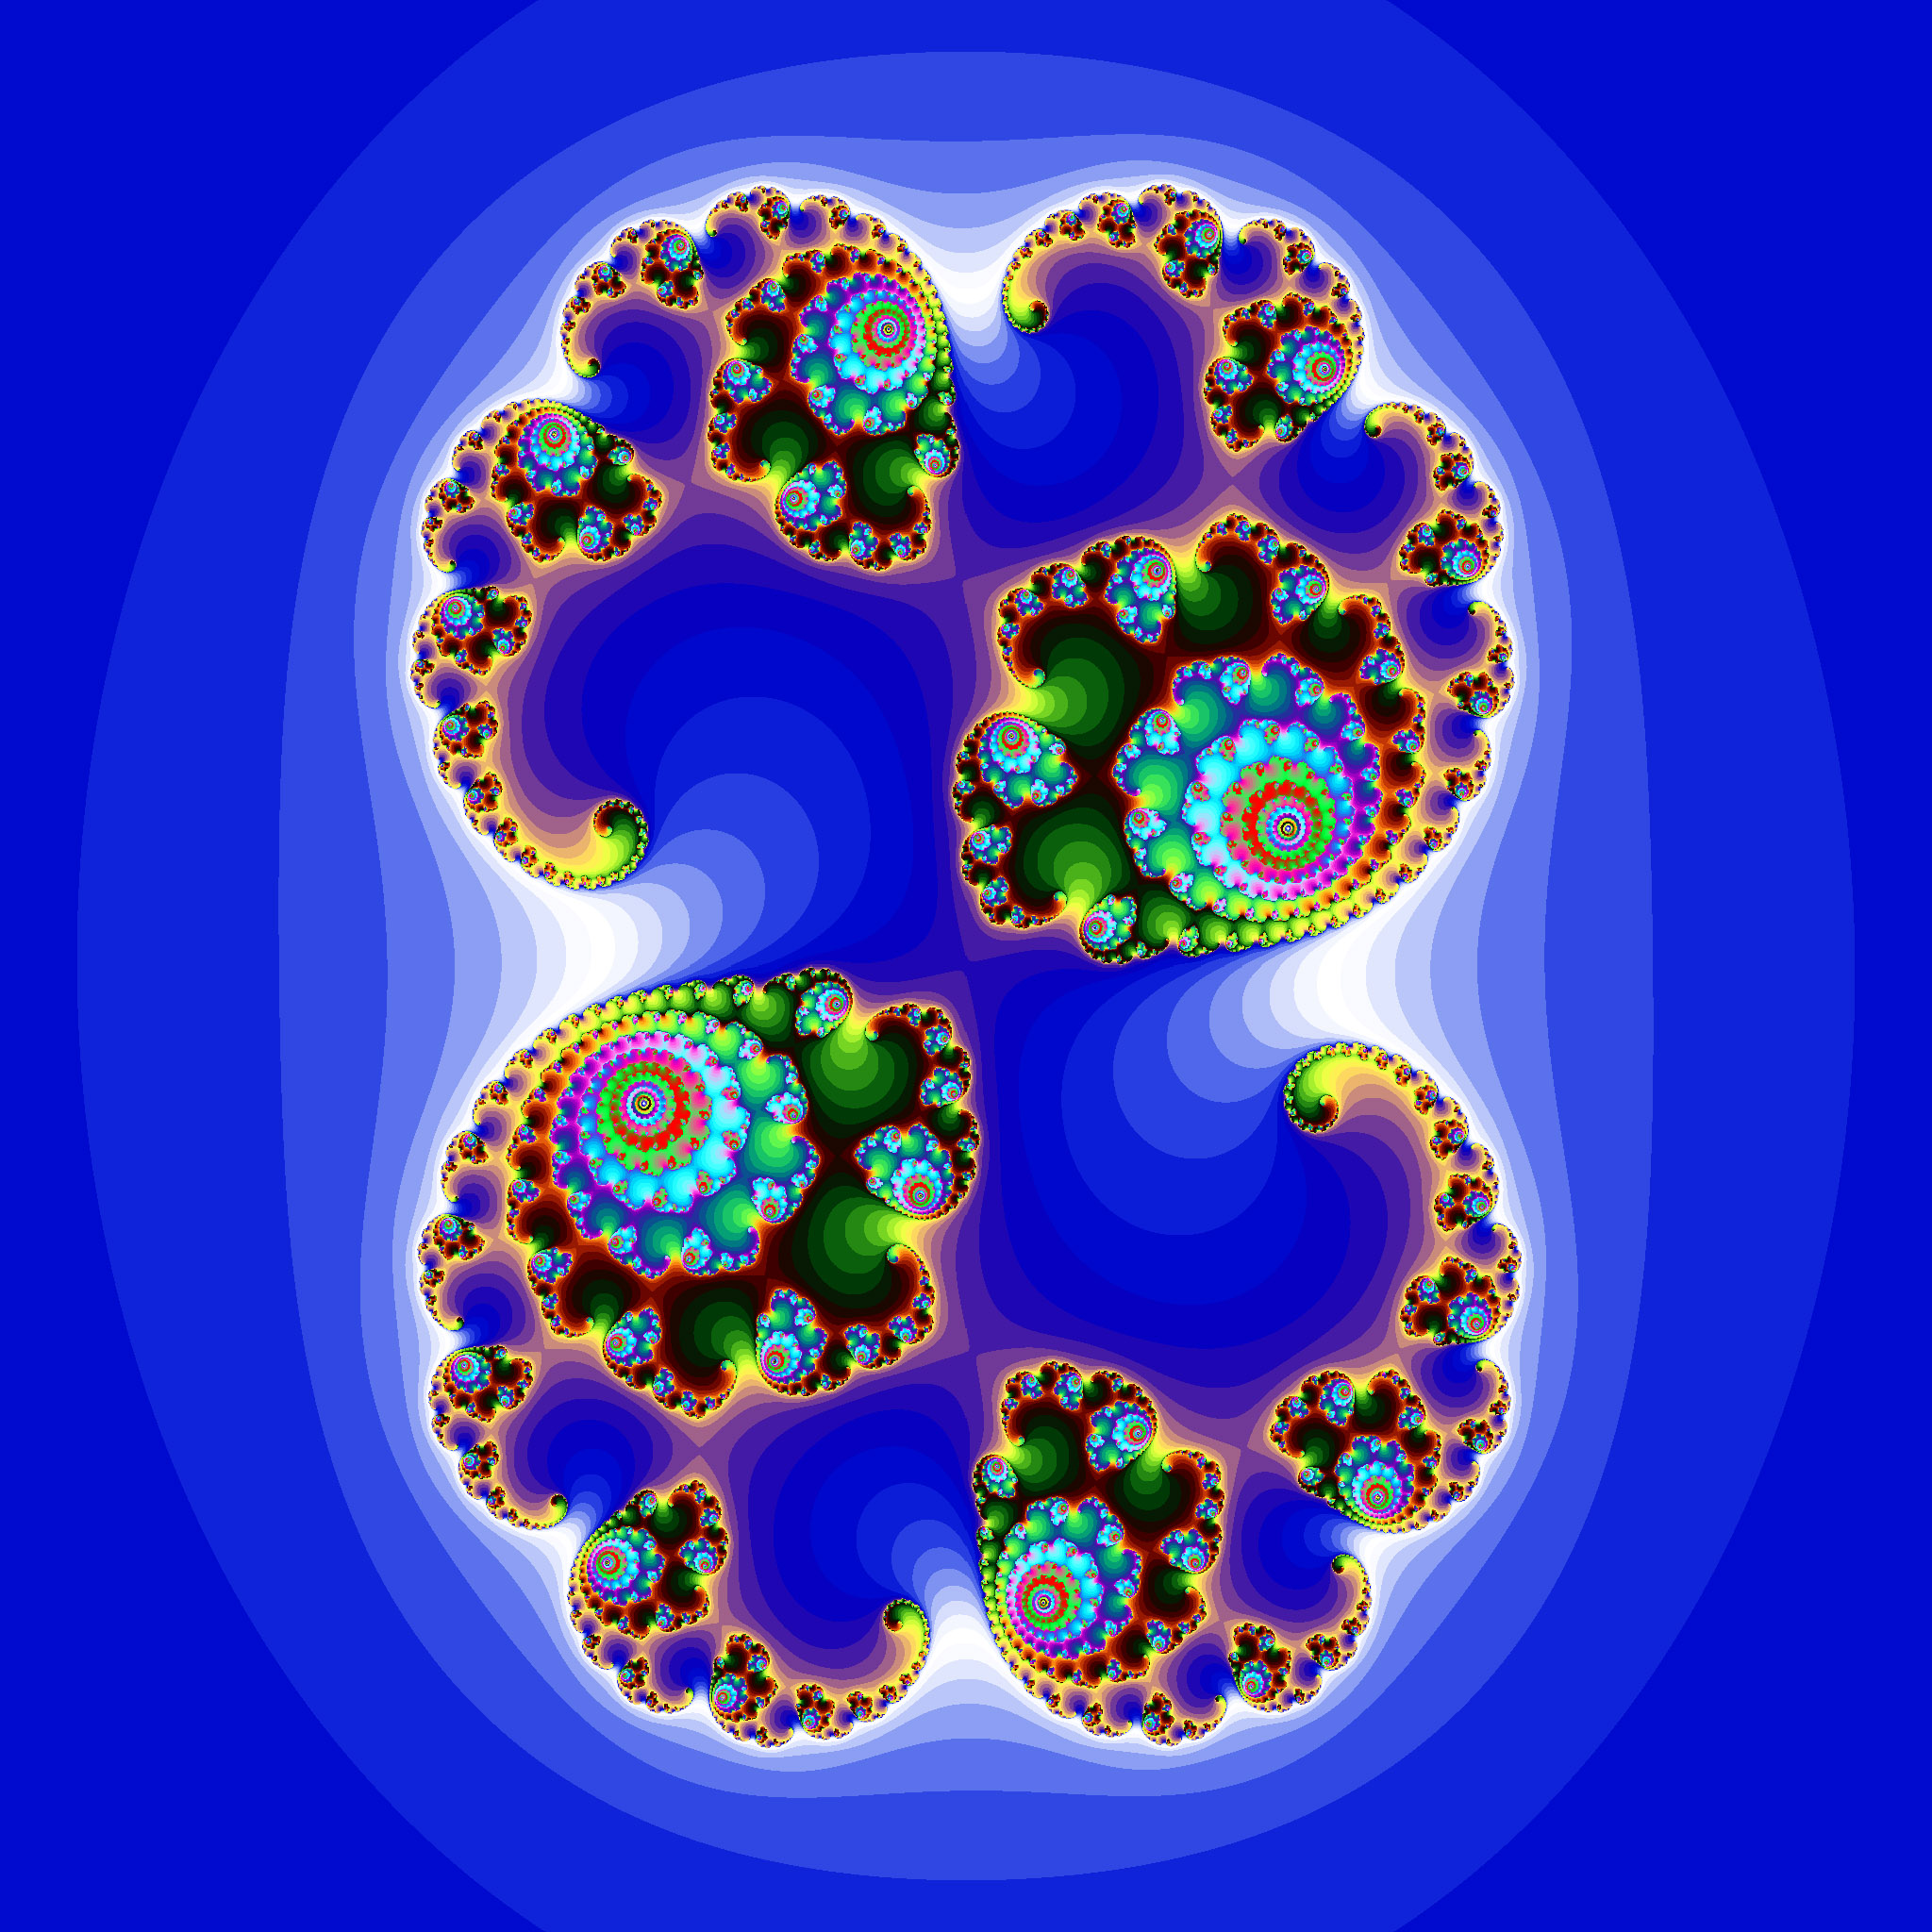

________________________________________________________________________________

**Zbiór Mandelbrota** - to zbiór punktów w przestrzeni kompleksowej, który jest generowany przez iteracyjne przekształcenie ciągu liczb zespolonych według określonej reguły. Podobnie jak zbiór Julia, zbiór Mandelbrota jest często wykorzystywany w grafice komputerowej do tworzenia abstrakcyjnych obrazów i animacji. Może również być używany w matematyce do badania własności funkcji kompleksowych. Zbiór Mandelbrota jest nazwany na cześć matematyka Benoîta Mandelbrota, który opisał go po raz pierwszy w latach 70. XX wieku i przyczynił się do rozwoju fraktalnej geometrii. Charakteryzuje się on typowymi dla fraktali nieskończenie złożonymi kształtami i nieregularną strukturą. W przestrzeni kompleksowej zbiór Mandelbrota odpowiada obszarowi, w którym iteracyjne przekształcenie ciągu liczb zespolonych zbiega do stałej wartości, podczas gdy poza tym obszarem przekształcenie to rozbiega do nieskończoności.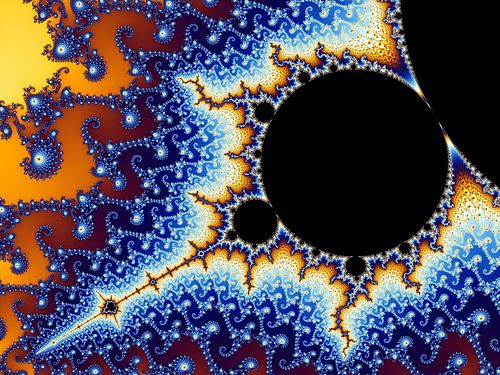
________________________________________________________________________________

**CUDA** - (Compute Unified Device Architecture) to architektura obliczeń równoległych firmy NVIDIA, która umożliwia programistom wykorzystanie mocy obliczeniowej kart graficznych (GPU) do obliczeń naukowych i innych zastosowań, w których wymagane są duże przepustowości danych. Dzięki CUDA programiści mogą napisać kod obliczeniowy w języku C lub C++ i uruchomić go na GPU za pomocą specjalnego API (Application Programming Interface). CUDA umożliwia równoległe wykonywanie wielu prostych obliczeń na raz, co pozwala na szybsze wykonanie złożonych zadań niż w przypadku wykorzystania procesora centralnego (CPU). Jest ona szczególnie przydatna w zastosowaniach takich jak modelowanie, symulacje, obliczenia naukowe i inżynieria.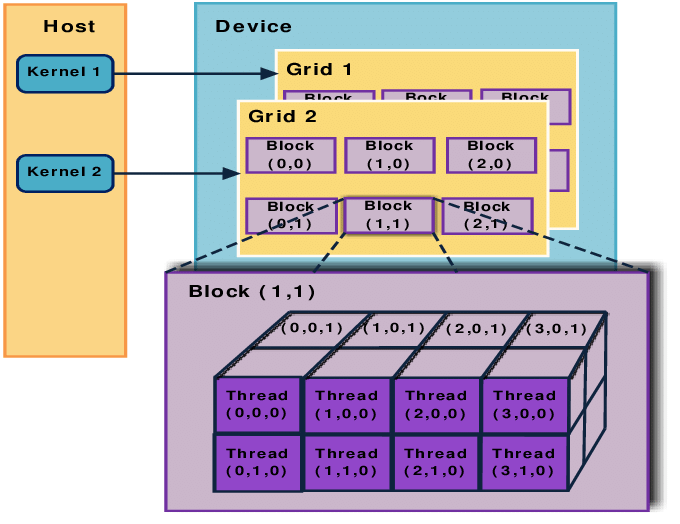

________________________________________________________________________________

1. Julia CPU

In [ ]:
%%cu 
#include<stdio.h>
#define DIM 2000

struct cuComplex{
    float r;
    float i;
    cuComplex(float a, float b):r(a),i(b){}
    float magnitude2(void){return r*r+i*i;}
    cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
    int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
    void kernel(unsigned char *ptr){
        for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            int juliaValue=julia(x,y);
            ptr[offset*4+0]=255*juliaValue;
            ptr[offset*4+1]=0;
            ptr[offset*4+2]=0;
            ptr[offset*4+3]=255;
          }
        }
    }
  
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


2. Julia GPU

In [ ]:
%%cu 
#include<stdio.h>
#define DIM 2000
struct cuComplex{
    float r;
    float i;
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i; }
    __device__ cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    __device__ cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
__device__ int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
__global__ void kernel(unsigned char *ptr){
    int x=blockIdx.x;
    int y=blockIdx.y;
    int offset=x+y*gridDim.x;

    int juliaValue=julia(x,y);
    ptr[offset*4+0]=255*juliaValue;
    ptr[offset*4+1]=0;
    ptr[offset*4+2]=0;
    ptr[offset*4+3]=255;
}
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    unsigned char *dev_bitmap;

    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap=dev_bitmap;
    dim3 grid(DIM,DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);
    cudaFree(dev_bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


Porównanie

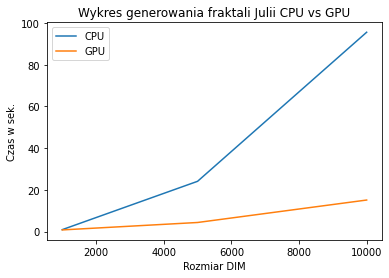

In [ ]:
import matplotlib.pyplot as plt

dims = (1000, 5000, 10000)
timeCPU = (0.947622, 24.114844, 95.583010)
timeGPU = (0.811615, 4.371521, 15.140495)


plt.plot(dims, timeCPU, label='CPU')
plt.plot(dims, timeGPU, label='GPU')
plt.xlabel("Rozmiar DIM")
plt.ylabel("Czas w sek.")
plt.title("Wykres generowania fraktali Julii CPU vs GPU")
plt.legend()
plt.show()

3. Mandelbrot CPU

In [ ]:
%%cu 
#include<stdio.h>
#define DIM 6000

struct cuComplex{
    float r;
    float i;
    cuComplex(float a, float b):r(a),i(b){}
    float magnitude2(void){return r*r+i*i;}
    cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
    int mandelbrot(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(jx,jy);
    cuComplex a(0,0);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
    void kernel(unsigned char *ptr){
        for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            int mandelbrotValue=mandelbrot(x,y);
            ptr[offset*4+0]=255*mandelbrotValue;
            ptr[offset*4+1]=0;
            ptr[offset*4+2]=0;
            ptr[offset*4+3]=255;
          }
        }
    }
  
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


4. Mandelbrot GPU

In [ ]:
%%cu
#include<stdio.h>
#define DIM 6000
struct cuComplex{
    float r;
    float i;
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i; }
    __device__ cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    __device__ cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
__device__  int mandelbrot(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(jx,jy);
    cuComplex a(0,0);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0; 
    }
    return 1;
}
__global__ void kernel(unsigned char *ptr){
    int x=blockIdx.x;
    int y=blockIdx.y;
    int offset=x+y*gridDim.x;

    int mandelbrotValue=mandelbrot(x,y);
    ptr[offset*4+0]=255*mandelbrotValue;
    ptr[offset*4+1]=0;
    ptr[offset*4+2]=0;
    ptr[offset*4+3]=255;
}
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1],ptr[offset*4+2]);
        }
}
fclose(fp);
}
                    


int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    unsigned char *dev_bitmap;

    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap=dev_bitmap;
    dim3 grid(DIM,DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);
    cudaFree(dev_bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


Porównanie

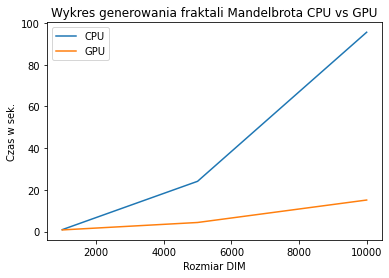

In [ ]:
import matplotlib.pyplot as plt

dims = (1000, 5000, 10000)
timeCPU = (0.947622, 24.114844, 95.583010)
timeGPU = (0.811615, 4.371521, 15.140495)


plt.plot(dims, timeCPU, label='CPU')
plt.plot(dims, timeGPU, label='GPU')
plt.xlabel("Rozmiar DIM")
plt.ylabel("Czas w sek.")
plt.title("Wykres generowania fraktali Mandelbrota CPU vs GPU")
plt.legend()
plt.show()